In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as un, constants as cons
from astropy.cosmology import WMAP7 as cosmo
import copy
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [2]:
#some handy constants
X = 0.75     # hydrogen mass fraction
mu = 4./(3.+5.*X) # mean molecular weight
mue = 2./(1.+X) # mean molecular weight per electron
muh = 1./X # mean molecular weight per hydrogen 
mp = cons.m_p.to('g').value # proton mass
me = cons.m_e.to('g').value # electron mass
kb = cons.k_B.to('erg / K').value # Boltzmann constant
sigma_T = cons.sigma_T.to('cm^2').value # thompson scattering cross-section
sol_c = cons.c.to('cm/s').value # speed of light
Msun = cons.M_sun.to('g').value # solar mass
Mpc = cons.kpc.to('cm').value*1e3
kev2ergs = 1.60218e-9

In [3]:
header_cluster = np.array(['UID', 'x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'x_pix', 'y_pix',
                           'i_sector', 'm500c[Msol/h]', 'r500c[kpc/h]', 'gas_frac',
                           'star_frac', 'T[kev]', 'Lx[1e44erg/s]', 'Y500c', 'M_sat/M_cD',
                           'cshift[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])


In [4]:
clusterfile = np.loadtxt('../cluster.txt')

In [5]:
h0 = cosmo.H0.value/100.
z = 0.03 
Ez = cosmo.H(z)/cosmo.H0 
m500c = clusterfile[:,np.where(header_cluster=='m500c[Msol/h]')[0][0]]/h0
'''idx = np.where(m500c>1e14)[0]
m500c = m500c[idx]
clusterfile = clusterfile[idx]'''
gas_frac = clusterfile[:,np.where(header_cluster=='gas_frac')[0][0]]
star_frac = clusterfile[:,np.where(header_cluster=='star_frac')[0][0]]
mgas = gas_frac*m500c
mstar = star_frac*m500c
vx = clusterfile[:,np.where(header_cluster=='vx[km/s]')[0][0]]*1e3 # cm/s
vy = clusterfile[:,np.where(header_cluster=='vy[km/s]')[0][0]]*1e3 # cm/s
vz = clusterfile[:,np.where(header_cluster=='vz[km/s]')[0][0]]*1e3 # cm/s
tgas = clusterfile[:,np.where(header_cluster=='T[kev]')[0][0]]*kev2ergs # ergs
Yksz = np.abs(mgas*Msun*vz*sigma_T/(sol_c*mue*mp*Mpc**2)) # in units mpc^2
Nclus = len(m500c)

In [6]:
from scipy.optimize import curve_fit

def power_law(x, norm, alpha): # this is your 'straight line' y=f(x)
    return norm+x*alpha

In [7]:
m500c_med = np.median(m500c)
lnX, lnYksz = np.log(m500c/m500c_med), np.log(Yksz)
fit_ksz, _ = curve_fit(power_law, lnX, lnYksz) 

In [8]:
lnYksz_p = power_law(lnX, fit_ksz[0], fit_ksz[1])
sigma_ksz = np.sqrt(((lnYksz-lnYksz_p)**2.).sum()/float(Nclus))
print (sigma_ksz)

1.144756036078561


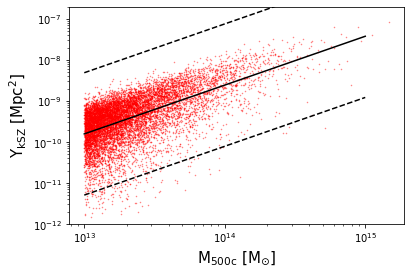

In [9]:
marr = np.linspace(13.,15.,10)
Yksz_p = np.exp(power_law(np.log(10.**marr/m500c_med), fit_ksz[0], fit_ksz[1]))
plt.plot(m500c,Yksz,'r.',markersize=1,alpha=0.5)
plt.plot(10.**marr,Yksz_p,'k-')
plt.plot(10.**marr,np.exp(np.log(Yksz_p)+3.*sigma_ksz),'k--')
plt.plot(10.**marr,np.exp(np.log(Yksz_p)-3.*sigma_ksz),'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm M_{500c}\,\, [M_{\odot}]$',fontsize=15)
plt.ylabel(r'$\rm Y_{kSZ}\,\, [Mpc^2]$',fontsize=15)
plt.ylim(1e-12,2e-7)
plt.show()

# 3-sigma clipping

In [10]:
#removing 3-sigma outliers
lnYksz_3sigma, lnYksz_p_3sigma, m500c_3sigma = copy.copy(lnYksz), copy.copy(
    lnYksz_p), copy.copy(m500c)
sigma_ksz = [sigma_ksz]

for i in range(30):
    print ('iteration =', i+1)
    idx = np.where(np.abs(lnYksz_3sigma-lnYksz_p_3sigma)<3.*sigma_ksz[-1])[0]
    m500c_3sigma = m500c_3sigma[idx]
    m500c_med_3sigma = np.median(m500c_3sigma)
    lnX_3sigma, lnYksz_3sigma = np.log(m500c_3sigma/m500c_med_3sigma), lnYksz_3sigma[idx]

    #re-fitting power law
    fit_ksz_3sigma, _ = curve_fit(power_law, lnX_3sigma, lnYksz_3sigma)

    #re-calculating sigma
    lnYksz_p_3sigma = power_law(lnX_3sigma, fit_ksz_3sigma[0], fit_ksz_3sigma[1])
    sigma_ksz = np.append(sigma_ksz, np.sqrt(((lnYksz_3sigma-lnYksz_p_3sigma)**2.).sum()/float(len(
        lnYksz_3sigma))))
    print ('scatter after removing outliers =', sigma_ksz[-1])
    Dsigma = 100*np.abs(sigma_ksz[-2]-sigma_ksz[-1])/sigma_ksz[-2]
    print ('% changes in scatter =', Dsigma)
    print ('')
    if Dsigma<0.5: break

iteration = 1
scatter after removing outliers = 1.0167692869158356
% changes in scatter = 11.180264189840187

iteration = 2
scatter after removing outliers = 0.9780190028758191
% changes in scatter = 3.811118661693414

iteration = 3
scatter after removing outliers = 0.9615787916771146
% changes in scatter = 1.6809705282170249

iteration = 4
scatter after removing outliers = 0.9557808492768302
% changes in scatter = 0.6029607194405853

iteration = 5
scatter after removing outliers = 0.954644667654332
% changes in scatter = 0.11887470055063815



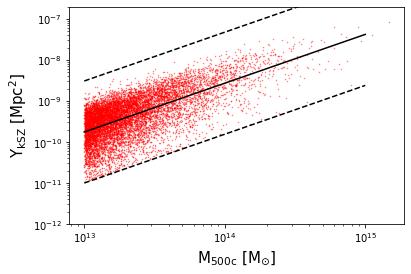

In [11]:
marr = np.linspace(13.,15.,10)
Yksz_p_3sigma = np.exp(power_law(np.log(10.**marr/m500c_med_3sigma), fit_ksz_3sigma[0], fit_ksz_3sigma[1]))
plt.plot(m500c_3sigma,np.exp(lnYksz_3sigma),'r.',markersize=1,alpha=0.5)
plt.plot(10.**marr,Yksz_p_3sigma,'k-')
plt.plot(10.**marr,np.exp(np.log(Yksz_p_3sigma)+3.*sigma_ksz[-1]),'k--')
plt.plot(10.**marr,np.exp(np.log(Yksz_p_3sigma)-3.*sigma_ksz[-1]),'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm M_{500c}\,\, [M_{\odot}]$',fontsize=15)
plt.ylabel(r'$\rm Y_{kSZ}\,\, [Mpc^2]$',fontsize=15)
plt.ylim(1e-12,2e-7)
plt.show()

In [14]:
print ('% of clusters removed in 3-sigma clipping =', 100-100*float(m500c_3sigma.size)/float(m500c.size))

% of clusters removed in 3-sigma clipping = 2.801867911941301


# Does random forest behave better with clipped data

In [30]:
def lnsigma(Y,Yp):
    return np.sqrt(((Y-Yp)**2).sum()/float(len(Y)))

In [22]:
yksz_data = pd.DataFrame(np.array([lnYksz_3sigma,m500c_3sigma]).T,
                         dtype=float,columns=['lnYksz','m500c'])

In [25]:
train_df, test_df = train_test_split(yksz_data, train_size=0.7, random_state=42)

In [26]:
def get_inp(features):
    xlen = len(features[0])
    ylen = len(features)
    inp = np.zeros((xlen,ylen))
    for i in range(len(features)):
        inp[:,i] = features[i]
    return inp

In [27]:
#all data
lnX1 = get_inp([np.log(yksz_data['m500c'])])
lnYksz = yksz_data['lnYksz']

#training set
x1 = train_df['m500c']
lnX1_train = get_inp([np.log(x1)])
lnYksz_train = train_df['lnYksz']

#testing set
lnX1_test = get_inp([np.log(test_df['m500c'])])
lnYksz_test = test_df['lnYksz']

In [28]:
regr = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=50,n_jobs=-1)
regr.fit(lnX1_train,lnYksz_train)

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0)

In [31]:
lnYksz_trainP = regr.predict(lnX1_train)
sigmakSZ_train = lnsigma(lnYksz_train,lnYksz_trainP)
print ('log-normal scatter on training set = ', sigmakSZ_train)

log-normal scatter on training set =  0.4406376899265527


In [32]:
lnYksz_testP = regr.predict(lnX1_test)
sigmakSZ_test = lnsigma(lnYksz_test,lnYksz_testP)
print ('log-normal scatter on testing set = ', sigmakSZ_test)

log-normal scatter on testing set =  1.1832327269868714


In [33]:
lnYksz_rf1 = regr.predict(lnX1)
sigmakSZ_rf1 = lnsigma(lnYksz,lnYksz_rf1)
print ('log-normal scatter on testing set = ', sigmakSZ_rf1)

log-normal scatter on testing set =  0.7456275732517592
